## Retrieval of PRISM Precipitation Data for the Logan River Watershed 

**Authors**:  
- Irene Garousi-Nejad <igarousi@cuahsi.org>
- Tony Castronova <acastronova@cuahsi.org>  

**Last Updated**: 05.08.2023

**Description**: 
    
This notebook fetches PRISM precipitation data and extracts a subset for a specific region using the spatial extent provided by the Logan River Watershed shapefile. The output will be a CSV file containing the daily precipitation data, with a spatial resolution of 4 km, averaged spatially across the watershed.

---

In [16]:
# if running it with the CUAHSI JupyterHub, you need to install cartopy
!pip install cartopy --quiet

In [69]:
import os
import subprocess

from rasterstats import zonal_stats
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from shapely.geometry import MultiPolygon
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

## 1. Load the Logan River Watershed

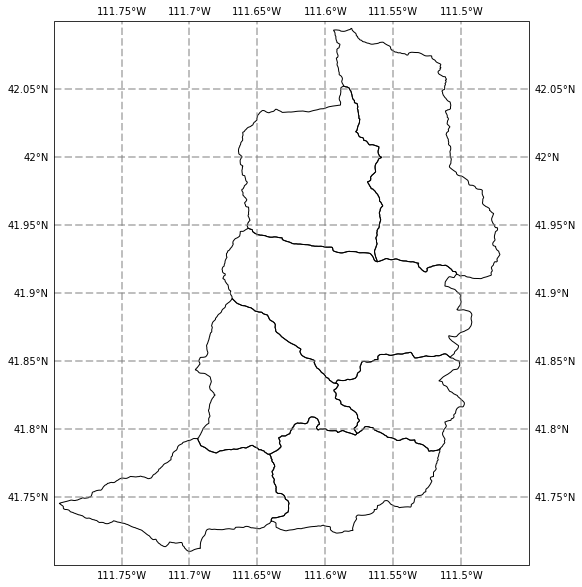

In [22]:
# load the Logan River Watershed 
mp = MultiPolygon(Reader('logan-watershed-huc12.shp').geometries())

# read the geometries for plotting
shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')

# visualize data on the map
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

shape_feature = ShapelyFeature(mp.geoms,
                                ccrs.PlateCarree(), facecolor='none')
ax.add_feature(shape_feature, zorder=1)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.set_ylim([41.70, 42.10]);
ax.set_xlim([-111.80, -111.45]);
ax.set_aspect('equal');
ax.coastlines();

The Logan River Watershed contains seven HUC 12 catchments. If we apply the `zonal_stats` function from the `rasterstats` library to this shapefile containing multiple geometries, the function calculates statistics separately for each individual geometry. However, in our case, we want to compute statistics for the entire watershed rather than for each individual catchment. To achieve this, we need to dissolve the multiple catchments into a single feature. By dissolving the geometries, we will merge them together to create a single polygon representing the entire watershed. This will allow us to calculate the desired statistics for the watershed as a whole.

In [23]:
# read data as a dataframe
watershed = read_file('./logan-watershed-huc12.shp')

# add a column with a constant value that will be used to dissolve the shapefile
watershed['temp']=1

# dissolve
watershed_dis = watershed.dissolve(by = 'temp', aggfunc = 'sum')

In [25]:
watershed_dis

,geometry,OBJECTID,AreaSqKm,AreaAcres,Shape_Leng,Shape_Area,NHDPlusID
temp,,,,,,,
1,"POLYGON ((-111.64008 41.73178, -111.64027 41.7...",515.0,556.24718,137451.55,3.216165,0.060335,4.900042e+14


## 2. Download PRISM Daily Precipitation Data

The PRISM web service provides a single file (i.e., grids in BIL format) per request. We will run the following bash script to perform a bulk download of multiple grid files. This downloads PRISM daily precipitation data (`ppt`) and saves these files into input_folde. The results are *_bil.zip spanning the calendar year **2010**. Note that this section takes some time to finish. 

Create a folder

In [53]:
%%bash
folder="./input_folder"

if [ ! -d "$folder" ]; then
    mkdir -p "$folder"
    echo "Directory created: $folder"
else
    echo "Directory already exists: $folder"
fi


Directory already exists: ./input_folder


Download data

In [63]:
%%bash
folder="./input_folder"
cd $folder

base_url="https://services.nacse.org/prism/data/public/4km"
clim_var="ppt"
start=$(date -d "2010-01-01" +"%Y%m%d")
stop=$(date -d "2010-09-30" +"%Y%m%d")

while [[ $start -le $stop ]]; do
    day=$(date -d "$start" +"%Y%m%d")
    wget --content-disposition "$base_url/$clim_var/$day" 
    sleep 2
    start=$(date -d "$start + 1 day" +"%Y%m%d")
done

--2023-05-09 02:27:21--  https://services.nacse.org/prism/data/public/4km/ppt/20100101
Resolving services.nacse.org (services.nacse.org)... 128.193.34.62
Connecting to services.nacse.org (services.nacse.org)|128.193.34.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198 [application/octet-stream]
Saving to: ‘PRISM_ppt_stable_4kmD2_20100101_bil_error_msg_3.txt’

     0K                                                       100% 5.71M=0s

2023-05-09 02:27:22 (5.71 MB/s) - ‘PRISM_ppt_stable_4kmD2_20100101_bil_error_msg_3.txt’ saved [198/198]

--2023-05-09 02:27:24--  https://services.nacse.org/prism/data/public/4km/ppt/20100102
Resolving services.nacse.org (services.nacse.org)... 128.193.34.62
Connecting to services.nacse.org (services.nacse.org)|128.193.34.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198 [application/octet-stream]
Saving to: ‘PRISM_ppt_stable_4kmD2_20100102_bil_error_msg_3.txt’

     0K                         

Unzip files

In [67]:
%%bash
folder="./input_folder"

for file in "$folder"/*.zip; do
    unzip "$file" -d "$folder"
done

Archive:  ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.zip
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.bil  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.hdr  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.prj  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.bil.aux.xml  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.stx  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.info.txt  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.stn.csv  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100103_bil.xml  
Archive:  ./input_folder/PRISM_ppt_stable_4kmD2_20100104_bil.zip
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100104_bil.bil  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100104_bil.hdr  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100104_bil.prj  
  inflating: ./input_folder/PRISM_ppt_stable_4kmD2_20100104_bil.bil.aux.xml  
  inf

In [30]:
# Unzip the downloaded file
!unzip "PRISM_ppt_stable_4kmD2_20100101_20101231_bil.zip"

Archive:  PRISM_ppt_stable_4kmD2_20100101_20101231_bil.zip
  inflating: PRISM_ppt_stable_4kmD2_20100101_bil.bil  
  inflating: PRISM_ppt_stable_4kmD2_20100101_bil.hdr  
  inflating: PRISM_ppt_stable_4kmD2_20100101_bil.prj  
  inflating: PRISM_ppt_stable_4kmD2_20100101_bil.bil.aux.xml  
  inflating: PRISM_ppt_stable_4kmD2_20100101_bil.stx  
  inflating: PRISM_ppt_stable_4kmD2_20100101_bil.info.txt  
  inflating: PRISM_ppt_stable_4kmD2_20100101_bil.stn.csv  
  inflating: PRISM_ppt_stable_4kmD2_20100102_bil.bil  
  inflating: PRISM_ppt_stable_4kmD2_20100102_bil.hdr  
  inflating: PRISM_ppt_stable_4kmD2_20100102_bil.prj  
  inflating: PRISM_ppt_stable_4kmD2_20100102_bil.bil.aux.xml  
  inflating: PRISM_ppt_stable_4kmD2_20100102_bil.stx  
  inflating: PRISM_ppt_stable_4kmD2_20100102_bil.info.txt  
  inflating: PRISM_ppt_stable_4kmD2_20100102_bil.stn.csv  
  inflating: PRISM_ppt_stable_4kmD2_20100103_bil.bil  
  inflating: PRISM_ppt_stable_4kmD2_20100103_bil.hdr  
  inflating: PRISM_ppt_stab

## 3. Use Consistent Projectinos

In [71]:
# Get a list of all .bil files in the folder
bil_files = [file for file in os.listdir("./input_folder") if file.endswith('.bil')]
bil_files[0:10]

['PRISM_ppt_stable_4kmD2_20100323_bil.bil',
 'PRISM_ppt_stable_4kmD2_20100221_bil.bil',
 'PRISM_ppt_stable_4kmD2_20100317_bil.bil',
 'PRISM_ppt_stable_4kmD2_20100828_bil.bil',
 'PRISM_ppt_stable_4kmD2_20100625_bil.bil',
 'PRISM_ppt_stable_4kmD2_20101230_bil.bil',
 'PRISM_ppt_stable_4kmD2_20101208_bil.bil',
 'PRISM_ppt_stable_4kmD2_20100820_bil.bil',
 'PRISM_ppt_stable_4kmD2_20101227_bil.bil',
 'PRISM_ppt_stable_4kmD2_20101213_bil.bil']

In [72]:
input_folder = './input_folder'  
output_folder = './output_folder'

# Loop through each .bil file and use gdalwrap to covert the projection
for bil_file in bil_files:
    
    # Specify the input and output file paths
    input_file = os.path.join(input_folder, bil_file)
    output_file = os.path.join(output_folder, bil_file)
    
    # Construct the gdalwarp command
    gdalwarp_cmd = f'gdalwarp -overwrite -t_srs EPSG:4269 {input_file} {output_file}'
    
    # Execute the gdalwarp command using subprocess
    subprocess.run(gdalwarp_cmd, shell=True)
    

Creating output file that is 1405P x 621L.
Processing ./input_folder/PRISM_ppt_stable_4kmD2_20100323_bil.bil [1/1] : 0Using internal nodata values (e.g. -9999) for image ./input_folder/PRISM_ppt_stable_4kmD2_20100323_bil.bil.
Copying nodata values from source ./input_folder/PRISM_ppt_stable_4kmD2_20100323_bil.bil to destination ./output_folder/PRISM_ppt_stable_4kmD2_20100323_bil.bil.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1405P x 621L.
Processing ./input_folder/PRISM_ppt_stable_4kmD2_20100221_bil.bil [1/1] : 0Using internal nodata values (e.g. -9999) for image ./input_folder/PRISM_ppt_stable_4kmD2_20100221_bil.bil.
Copying nodata values from source ./input_folder/PRISM_ppt_stable_4kmD2_20100221_bil.bil to destination ./output_folder/PRISM_ppt_stable_4kmD2_20100221_bil.bil.
...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1405P x 621L.
Processing ./input_folder/PRISM_ppt_stable_4kmD2_20100317_bil.b

## 4. Subset PRISM Data for the Logan River Watershed

Use `zonal_stat` to compute the statistics of the PRISM data clipped for the watershed boundary. Note that we are interested in the `mean` values. Create a dataframe that contains dates and spatially averaged daily precipitation values. 

In [73]:
# Get a list of all .bil files in the folder
bil_files = [file for file in os.listdir("./output_folder") if file.endswith('.bil')]
bil_files

date=[]
p=[]

# Loop through each .bil file
for bil_file in bil_files:

    stats=zonal_stats("logan-watershed-huc12.shp",bil_file)
    
    import pandas as pd
    date.append(pd.to_datetime(bil_file.split("_")[-2]))
    
    p.append(stats[0]['mean'])
    

df = pd.DataFrame({'Date': date, 'Precipitation (mm)': p})

In [74]:
# sort the dataframe based on dates
df = df.sort_values(by='Date')

In [75]:
# save the dataframe as a CSV file
df.to_csv('Daily_PRISM_Precipitation_in_2010_for_LoganRiverWatershed.csv')

## 5. Plot the Precipitation Timeseries

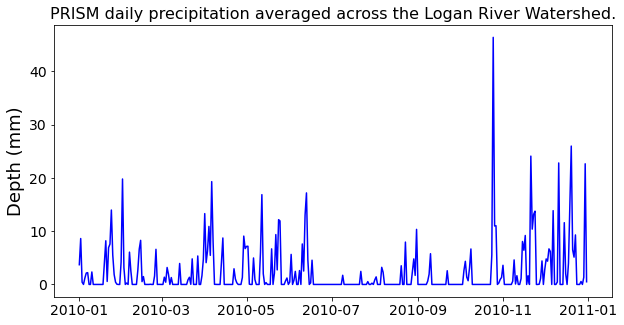

In [97]:
fig, ax = plt.subplots(figsize=(10,5))
import matplotlib.pyplot as plt
ax.plot(df['Date'], df['Precipitation (mm)'], color='b')
ax.set_ylabel('Depth (mm)', size=18)
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.set_title('PRISM daily precipitation averaged across the Logan River Watershed.', size=16)
plt.show()

In [98]:
df

,Date,Precipitation (mm)
317,2010-01-01,3.705833
241,2010-01-02,8.620167
199,2010-01-03,0.421333
192,2010-01-04,0.003833
65,2010-01-05,1.213833
...,...,...
8,2010-12-27,0.556833
306,2010-12-28,0.000000
62,2010-12-29,1.353167
5,2010-12-30,22.649333
